# Demonstrate TOA simulation using PINT

In [1]:
from pint.models import get_model
from pint.simulation import (
    make_fake_toas_uniform,
    make_fake_toas_fromtim,
)
from pint.residuals import Residuals, WidebandTOAResiduals
from pint.logging import setup as setup_log
from pint import dmu
from pint.config import examplefile

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import io

# Turn logging level to warnings and above
setup_log(level="WARNING")

1

## Basic example

In [2]:
# First, let us create a simple model from which we will simulate TOAs.
m = get_model(
    io.StringIO(
        """
        RAJ             05:00:00
        DECJ            20:00:00
        PEPOCH          55000
        F0              100
        F1              -1e-14
        DM              15
        PHOFF           0
        EFAC tel gbt    1.5
        TZRMJD          55000
        TZRFRQ          1400
        TZRSITE         gbt
        EPHEM           DE440
        CLOCK           TT(BIPM2019)
        UNITS           TDB
        """
    )
)

In [3]:
# The simplest type of simulation we can do is narrowband TOAs with uniformly
# spaced epochs (one TOA per epoch) with a single frequency and equal TOA uncertainties.
tsim = make_fake_toas_uniform(
    model=m,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=1400 * u.MHz,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
)

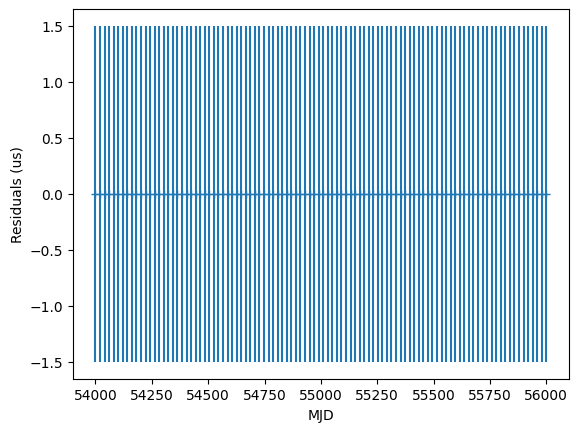

In [4]:
# Let us try plotting the residuals
res = Residuals(tsim, m)

plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")
plt.show()

Here we see that the TOAs don't have the expected white
noise. The noise should be 1.5 us, including the EFAC.
The noise can be included by using the `add_noise` option.

In [5]:
tsim = make_fake_toas_uniform(
    model=m,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=1400 * u.MHz,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
    add_noise=True,
)

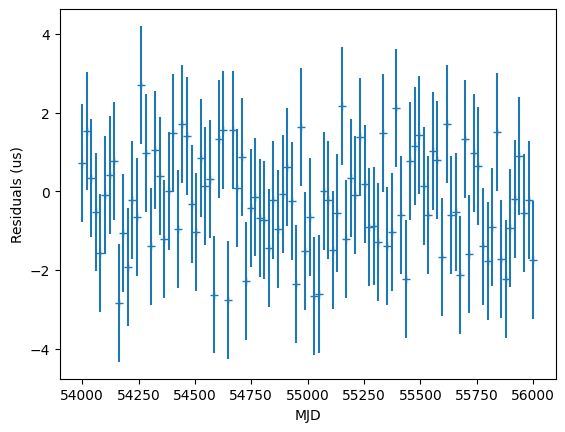

In [6]:
res = Residuals(tsim, m)

plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")
plt.show()

The same thing can be achieved in the command line using
the following command:

      $ zima --startMJD 54000 --ntoa 100 --duration 2000 --obs gbt --freq 1400 --error 1 --addnoise test.par test.tim

## Multiple frequency example

Multiple frequency TOAs can be simulated by passing an array of frequencies
into the `freq` parameter.

In [7]:
freqs = np.linspace(1000, 2000, 4) * u.MHz
tsim = make_fake_toas_uniform(
    model=m,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=freqs,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
    add_noise=True,
)

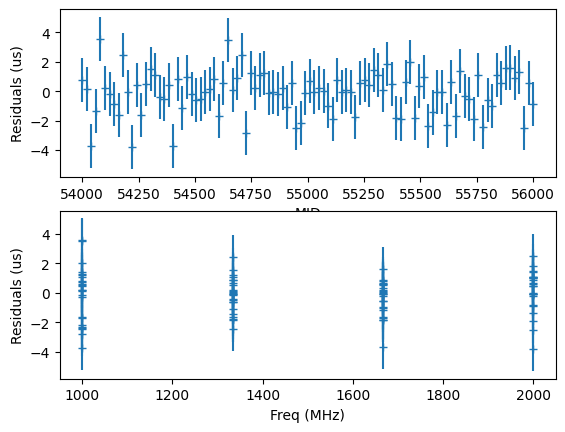

In [8]:
res = Residuals(tsim, m)

plt.subplot(211)
plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")

plt.subplot(212)
plt.errorbar(
    tsim.get_freqs(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("Freq (MHz)")
plt.ylabel("Residuals (us)")
plt.show()

We see that the frequencies are distributed amongst epochs such that
there is only one TOA per epoch. To distribute the TOAs such that each
epoch contains all frequencies, use the `multi_freqs_in_epoch` option.
Note that this option doesn't change the total number of TOAs.

In [9]:
freqs = np.linspace(1000, 2000, 4) * u.MHz
tsim = make_fake_toas_uniform(
    model=m,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=freqs,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
    add_noise=True,
    multi_freqs_in_epoch=True,
)

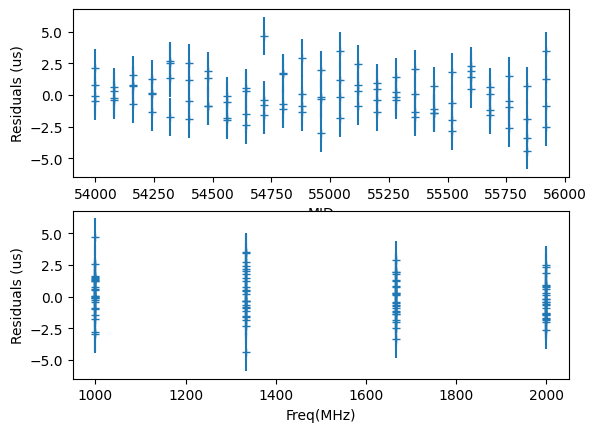

In [10]:
res = Residuals(tsim, m)

plt.subplot(211)
plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")

plt.subplot(212)
plt.errorbar(
    tsim.get_freqs(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("Freq(MHz)")
plt.ylabel("Residuals (us)")
plt.show()

The same thing can be achieved in the command line using
the following command:

      $ zima --startMJD 54000 --ntoa 100 --duration 2000 --obs gbt --freq 1000 1333.33 1666.67 2000 --error 1 --addnoise --multifreq test.par test.tim

## Correlated noise simulation example

If there is a correlated noise component in the timing model,
an instance of that noise can be injected into the TOAs using
the `add_correlated_noise` option.

In [11]:
m1 = get_model(
    io.StringIO(
        """
        RAJ             05:00:00
        DECJ            20:00:00
        PEPOCH          55000
        F0              100
        F1              -1e-14
        DM              15
        PHOFF           0
        EFAC tel gbt    1.5
        TNREDAMP        -13
        TNREDGAM        4
        TZRMJD          55000
        TZRFRQ          1400
        TZRSITE         gbt
        EPHEM           DE440
        CLOCK           TT(BIPM2019)
        UNITS           TDB
        """
    )
)

tsim = make_fake_toas_uniform(
    model=m1,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=1400 * u.MHz,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
    add_noise=True,
    add_correlated_noise=True,
)

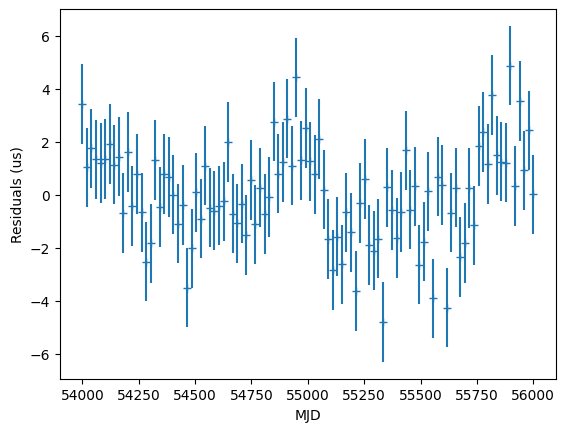

In [12]:
res = Residuals(tsim, m1)

plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")
plt.show()

The same thing can be achieved in the command line using
the following command:

      $ zima --startMJD 54000 --ntoa 100 --duration 2000 --obs gbt --freq 1400 --error 1 --addnoise --addcorrnoise test.par test.tim

## Wideband TOA simulation example

Wideband TOAs can be simulated using the `wideband` option.
The white noise RMS for the wideband DMs is controlled using
the `wideband_dm_error` parameter.

In [13]:
m2 = get_model(
    io.StringIO(
        """
        RAJ             05:00:00
        DECJ            20:00:00
        PEPOCH          55000
        F0              100
        F1              -1e-14
        DMEPOCH         55000
        DM              15
        DM1             1
        DM2             0.5
        PHOFF           0
        EFAC tel gbt    1.5
        TZRMJD          55000
        TZRFRQ          1400
        TZRSITE         gbt
        EPHEM           DE440
        CLOCK           TT(BIPM2019)
        UNITS           TDB
        """
    )
)

tsim = make_fake_toas_uniform(
    model=m2,
    startMJD=54000,
    endMJD=56000,
    ntoas=100,
    freq=1400 * u.MHz,
    obs="gbt",
    error=1 * u.us,
    include_bipm=True,
    include_gps=True,
    wideband=True,
    wideband_dm_error=1e-5 * dmu,
    add_noise=True,
)

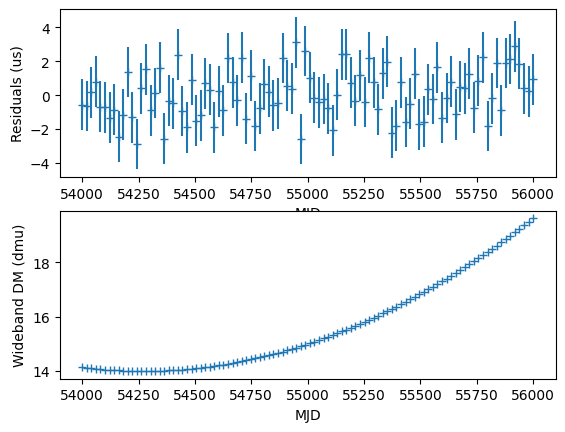

In [14]:
res = WidebandTOAResiduals(tsim, m2)

plt.subplot(211)
plt.errorbar(
    tsim.get_mjds(),
    res.toa.time_resids.to_value("us"),
    res.toa.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")

plt.subplot(212)
plt.errorbar(
    tsim.get_mjds(),
    tsim.get_dms().to_value(dmu),
    res.dm.get_data_error().to_value(dmu),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Wideband DM (dmu)")
plt.show()

The same thing can be achieved in the command line using
the following command::

      $ zima --startMJD 54000 --ntoa 100 --duration 2000 --obs gbt --freq 1400 --error 1 --addnoise --wideband --dmerror 1e-5 test.par test.tim

## Simulating TOAs based on a tim file

TOAs can be simulated to match the configuration of an existing tim file
(e.g. epochs, TOA uncertainties, frequencies, flags, etc.) using the
`make_fake_toas_fromtim` function. This also works with wideband tim files.

In [15]:
tsim = make_fake_toas_fromtim(
    timfile=examplefile("B1855+09_NANOGrav_9yv1.tim"),
    model=m,
    add_noise=True,
)

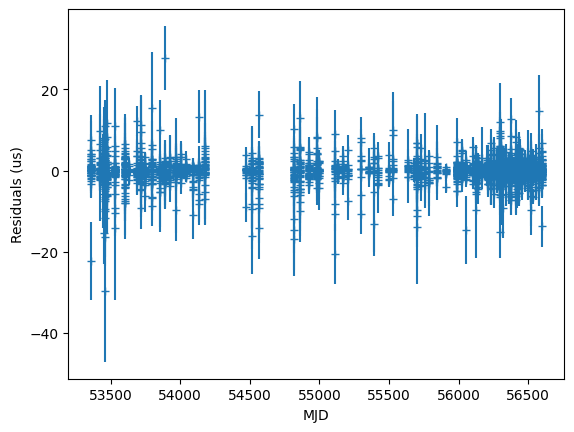

In [16]:
res = Residuals(tsim, m)

plt.errorbar(
    tsim.get_mjds(),
    res.time_resids.to_value("us"),
    res.get_data_error().to_value("us"),
    marker="+",
    ls="",
)
plt.xlabel("MJD")
plt.ylabel("Residuals (us)")
plt.show()

The same thing can be achieved in the command line using
the following command::

      $ zima --inputtim B1855+09_NANOGrav_9yv1.tim --addnoise test.par test.tim